# Pricing Asian Arithmetic Option using Monte Carlo Simulations

Asian arithmetic options are a type of exotic options as it is path depending. This certainly means that either the strike price or the payoffs is obtained by aggregating the underlying asset prices during the option period. In this article, I have averaged the respective payoffs obtained on simulated stock prices, using a fixed strike price.
As there is no closed form analytical formula for pricing these kinds, we will use payoff of geometric option as a control variate for estimating the analytical price of arithmetic option. 
The payoff of Arithmetic Option is represented below :

$$\left(\frac{1}{N+1} \sum_{i=0}^N S_{t_i}-K\right)_{+}$$

Its value may be computed using straight Monte Carlo simulations. However, in order to obtain a small standard error, the number of simulations must be very high. The computational implementation of Simple Monte Carlo Simulation is shown below. Also, this project represents a method of making this entire process time efficient by bridging C and Python using cython.

 Our primary assumption before implementing Monte Carlo simulations is that the stocks have behavior pattern of Geometric Brownian Motion. So in order to obtain these simulation we will model the stock price as shown below:
 $$S(\Delta t)=S(0) e^{\left(\left(\mu-\frac{\sigma^2}{2}\right) \Delta t+(\sigma \sqrt{\Delta t}) \epsilon\right)}$$

The $\epsilon$ in above equation represents Brownian Motion and is the source of randomness in our model. In the following code chunk, I have implemented Monte Carlo simulations using Numpy and Vectorization

In [1]:
import numpy as np
import math as m
import cython
%load_ext Cython

In [2]:
import time
start_time = time.time()
np.random.seed(1)
def sim_stocks(S0, r,sigma,steps =252,T=5):
    nSims = 10000
    sim_steps = steps*T
    dt = 1/steps
    div = 0
    mu = (r-div-0.5*sigma*sigma)*dt
    sigma = sigma*m.sqrt(dt)
    St = np.zeros(shape=(sim_steps,nSims))
    St[0,] = S0
    for i in range(1,sim_steps):
            for j in range(0,nSims):
                e = np.random.randn(1)
                St[i,j] = St[i-1,j]*m.exp(mu+sigma*e)
    return(St)

sim_stocks = np.vectorize(sim_stocks)
sim_stocks = sim_stocks(100,0.03,sigma=0.3,steps = 252,T=5)
print("The normal numpy execution with vectorization takes {0} seconds ".format(time.time() - start_time))

The normal numpy execution with vectorization takes 99.91290497779846 seconds 


As, you can below that total execution time was 99.91290 seconds which is very huge considering the fact that numpy is optimized and powerful tool. This time inefficiency is because of the complexity of the algorithm which we have used.

## Cython

However, the above problem can be tackled using Cython which is a superset of Python and it gives C-like performance. It is really powerful tool to increase the efficiency of complex algorithm. The following chunk shows how to make a cython code.

In [3]:
%%cython
import time
start_time = time.time()
cdef extern from "math.h":
    double sqrt(double x)
    double exp(double x)
import numpy as np
cimport numpy as np
# cimport math as m
cdef double S0
cdef double r
cdef double sigma
cdef int steps
cdef int T
np.random.seed(1)
cpdef sim_stocks(S0, r,sigma,steps =252,T=5):
    cdef int nSims = 10000
    cdef int sim_steps = steps*T
    cdef double dt = 1/steps
    cdef int div = 0
    cdef double mu = (r-div-0.5*sigma*sigma)*dt
    sigma = sigma*sqrt(dt)
    St = np.zeros(shape=(sim_steps,nSims))
    St[0,] = S0
    for i in range(1,sim_steps):
            for j in range(0,nSims):
                e = np.random.randn(1)
                St[i,j] = St[i-1,j]*exp(mu+sigma*e)
    return(St)

sim_stocks = sim_stocks(100,0.03,sigma=0.3,steps = 252,T=5)
print("The cythonized execution takes {0} seconds ".format(time.time() - start_time))

Content of stderr:
In file included from /home/liyang/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /home/liyang/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/liyang/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/liyang/.cache/ipython/cython/_cython_magic_1e5f1d8737cf2e321708bca96a236d565f79b319.c:1108:
/home/liyang/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~The cythonized execution takes 47.524577140808105 seconds 


As you can see above that total execution time for cython algorithm was 47.524 seconds.

## Data Visualization

In [7]:
import pandas as pd
data=pd.DataFrame(sim_stocks)

In [9]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,103.111188,98.844663,99.000921,97.986867,101.642863,95.738036,103.346199,98.565885,100.598760,99.523919,...,103.699093,99.893445,98.481905,99.245501,98.920391,100.132013,100.922594,98.095858,99.875640,97.313476
2,102.866686,99.265893,98.338115,96.455133,101.136559,96.039219,104.664004,97.952449,100.014062,100.510028,...,104.448078,98.353791,94.600402,96.608331,101.010530,98.357123,102.419466,102.657761,101.549805,97.124704
3,99.173535,98.959506,96.797841,96.074438,103.111048,97.810087,104.210140,97.742475,98.879160,102.681434,...,106.120479,94.650093,94.530725,94.330246,103.120147,99.641814,103.488922,102.489138,99.110295,97.749231
4,99.893780,98.024566,99.174160,95.431390,107.569147,102.923968,106.053757,96.861283,97.855577,101.779097,...,106.819682,94.759727,95.984286,94.002232,100.414456,100.251454,106.379650,104.895380,100.354540,97.822446


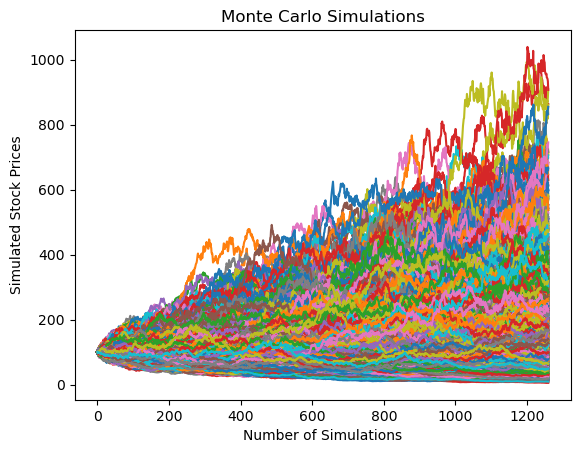

In [11]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.title("Monte Carlo Simulations")
plt.xlabel("Number of Simulations")
plt.ylabel("Simulated Stock Prices")
plt.show()

##  Evaluating the price of arithmetic option

In [12]:
S0=100
sigma=0.3
K=100
r=0.03
T=5
Nt=T*252 #number of trading days until maturity
sim_stocks = pd.DataFrame(sim_stocks)
prices = []
Y = []
steps=252
sim_steps = steps*5
for i in range(0,sim_steps):
    prices.append(np.mean(sim_stocks [i])) # Taking the arithmetic mean
    Y.append(max(prices[i]-K,0)*m.exp(-r*T))
arithmetic_opt_price  = np.mean(Y)
arithmetic_opt_price


17.726172152386773